# A short tutorial on how to use USTC-Pickers (<3 min)
* Author: [Jun Zhu](http://home.ustc.edu.cn/~zhujun2316/)
* Dependencies: [SeisBench](https://github.com/seisbench/seisbench)

## Instantiate a picker

In [15]:
import seisbench
import seisbench.models as sbm
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
from obspy.core.stream import Stream
from obspy.core.trace import Trace
import matplotlib.pyplot as plt
from config import *

# Instatiate a picker
picker = sbm.PhaseNet(phases='PSN', sampling_rate=sample_rate)
# print(picker) ## Uncomment this line to see a detailed description of the PhaseNet model

## Load a picker for your region

In [11]:
# Load a picker suitable for your region
location = input('Plase specify a region or province to pick phases, e.g. Beijing. 41 pickers are available now in the subfolder "USTC-Pickers/model_list/"')
if location not in en2cn:
    raise UserWarning('The region you specified is not available. Please choose a region or province listed below:\n%s.'%(', '.join(en2cn)))
else:
    model_save_path = glob.glob(os.path.join(model_list, '*'+en2cn[location]+'.pt'))[0]
    print('You are using the picker located at %s'%model_save_path)
    picker.load_state_dict(torch.load(model_save_path,
			map_location=device).state_dict())

Plase specify a region or province to pick phases, e.g. Beijing. 41 pickers are available now in the subfolder "USTC-Pickers/model_list/"Beijing
You are using the picker located at ../model_list/6_北京市.pt


## Plot the response, take a 180-s waveform as an example

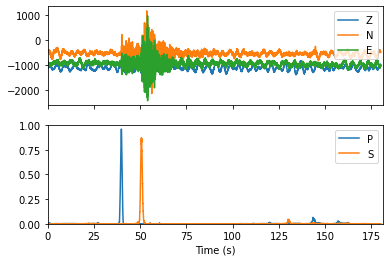

In [13]:
# Calculate the response
order = ['Z', 'N', 'E']
data = np.load(npz)['data']
stream = Stream([Trace(x, {'channel':'BH%s'%y, 'delta':1/sample_rate}) for x,y in
		zip(data.transpose(), order)])
response = picker.annotate(stream)
# Plot the response
fig, ax = plt.subplots(2, 1, sharex=True)
t = np.arange(data.shape[0])/sample_rate
ax[0].plot(t, data, label=order)
ax[1].plot(t, np.array([x.data for x in response[:-1]]).transpose(), label=['P', 'S'])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylim(0, 1)
for j in ax:
    j.legend()
    j.set_xlim(0, t.max()+1)
plt.show()
plt.close()

## Predict the P/S picks

In [14]:
picks = picker.classify(stream, P_threshold=.3, S_threshold=.3) # Threshold can be tuned for your target
for x in picks:
    print(x)

..	1970-01-01T00:00:39.820000Z	P
..	1970-01-01T00:00:50.640000Z	S
